In [6]:
import sys
sys.path.append("C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//common_funcs")
import cohpfuncs as cfunc
import jdftxfuncs as jfunc
data_dir = "E://perl//pscratch//beri9208//pot_scan//PtPyrOpt//"
import numpy as np
import matplotlib.pyplot as plt
save_dir = "C://Users//User//Desktop//pcoop_plots//"
import time
import os
import matplotlib.colors as mcolors
from numba import jit
import os
os.environ['OMP_NUM_THREADS'] = '1'  # set the value to 4

In [13]:
def app_dir(surf_idx, mu_idx):
    """
    :param surf_idx: 0 --> 2n-cis, 1 --> 2n-trans
    :param mu_idx: 0 --> No_bias, -1 --> dneg/1, 1 --> 2pos/1
    :return:
    """
    out_str = ""
    if surf_idx:
        out_str += "2n-trans//"
    else:
        out_str += "2n-cis//"
    if mu_idx == 0:
        out_str += "No_bias//"
    else:
        if mu_idx > 0:
            out_str += "dpos//"
        else:
            out_str += "dneg//"
        out_str += str(int(abs(mu_idx))) + "//"
    return data_dir + out_str

surf_labels = ["cis", "trans"]
bias_labels = ["-0.3V", "0.0V", "0.3V", "0.6", "0.9V", "-1.5V", "-1.2V","-0.9V", "-0.6V"]

def gen_dirname(lookat1, lookat2, surf_idx, save_dir):
    slabel = surf_labels[surf_idx]
    out_str = save_dir + slabel
    out_str += lookat1.split(' #')[0]
    out_str += lookat1.split(' #')[1]
    out_str += '-'
    out_str += lookat2.split(' #')[0]
    out_str += lookat2.split(' #')[1]
    out_str += '//'
    return out_str

def lb_idx(Emin, dE, sample):
    a = sample-Emin
    b = a/dE
    c = int(np.floor(b))
    return c, abs(b-c)

def lsstr(atom_label):
    saveable_string = ""
    use = atom_label.split(" #")
    for u in use:
        saveable_string += u
    return saveable_string


def system_atomwise_pcoop_matrix_all(surf_idx, bias_idx):
    proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
        app_dir(surf_idx, bias_idx) + "bandProjections",
        app_dir(surf_idx, bias_idx) + "Gvectors",
        app_dir(surf_idx, bias_idx) + "eigenvals")
    orbs_dict = cfunc.orbs_idx_dict(app_dir(surf_idx, bias_idx) + "out", nOrbsPerAtom)
    S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + "out")
    T_juk, P_uvjk, e_jk = cfunc.prepare_small_funcs(proj, E, numba=True)
    nk, nj = np.shape(E)
    orbital_labels = []
    maxint = max(orbs_dict["Pt #1"]) + 2
    for i in range(maxint):
        orbital_labels.append("n/a")
    pt_orbs = ["6s", "6px", "6py", "6pz", "7px", "7py", "7pz", "5dxy", "5dyz", "5dxz", "5dx2y2", "5dz2"]
    ticker = 0
    for atom in orbs_dict.keys():
        if ("C " in atom) or ("N " in atom):
            orbital_labels[ticker] = "2s"
            orbital_labels[ticker + 1] = "2px"
            orbital_labels[ticker + 2] = "2py"
            orbital_labels[ticker + 3] = "2pz"
            ticker += 4
        else:
            for orb in pt_orbs:
                orbital_labels[ticker] = orb
                ticker += 1
    orbs_sample = np.ones([len(orbs_dict.keys()), 12]) * (-1)
    for i, keyi in enumerate(orbs_dict.keys()):
        for j, idxj in enumerate(orbs_dict[keyi]):
            orbs_sample[i][j] = orbs_dict[keyi][j]

    @jit(nopython=True)
    def get_overlap_matrix(wk, orbs_sample, nk, nj, out):
        for i in range(len(orbs_sample)):
            for j in range(len(orbs_sample)):
                for u1 in orbs_sample[i]:
                    if u1 > 0:
                        for v1 in orbs_sample[j]:
                            if v1 > 0:
                                for ik in range(nk):
                                    for ij in range(nj):
                                        out[i,j] += P_uvjk(u1, v1, ij, ik) * wk[ik]
                                        # t1 = proj[ik][ij][u1]
                                        # t2 = proj[ik][ij][v1]
                                        # t1_conj = t1.real - t1.imag * 1j
                                        # out[i, j] += abs(t1_conj * t2) * abs(wk[ik])

        return out
    ## JIT THIS UP
    ###############
    pcoops_list = get_overlap_matrix(np.array(wk), np.array(orbs_sample, dtype=int), nk, nj, np.zeros([len(orbs_sample), len(orbs_sample)], dtype=np.complex128))
    ###############
    """
    pcoops_list: 2d list
    Erange: 1d range
    titles_and_idcs_and_mu: [title, data i/j pair, mu]
    """
    return pcoops_list, mu, orbs_dict.keys()

def avg_pos(ionPosns, i1, i2):
    avg = ionPosns[i1] + ionPosns[i2]
    return avg / 2

def ticklabels(vmin, vmax, npts, sigfigs=3):
    step = (vmax - vmin)/npts
    stepc = 1 / (npts - 1)
    tick_pts = []
    ticklabels = []
    for i in range(npts):
        ticklabels.append(f'{(vmin + (i * step)):.{sigfigs}g}')
        tick_pts.append(i * stepc)
    return tick_pts, ticklabels

data_prefix = "output."

In [14]:
surf_idx = 0
bias_idx = 0
proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
        app_dir(surf_idx, bias_idx) + "bandProjections",
        app_dir(surf_idx, bias_idx) + "Gvectors",
        app_dir(surf_idx, bias_idx) + "eigenvals")

In [9]:
T_juk, P_uvjk, e_jk = cfunc.prepare_small_funcs(proj, E)

In [10]:
P_uvjk(0, 0, 0, 0)

(1.2460899999999998e-09+0j)

In [11]:
T_juk(0, 0, 1)

(-3.0199999999999995e-05+0j)

In [15]:
datum = []
times = []
bidrange = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
for sidx in [0,1]:
    datum.append([])
    for bidx in bidrange:
        start = time.time()
        datum[-1].append(system_atomwise_pcoop_matrix_all(sidx, bidx))
        end = time.time()
        elapsed = end - start
        times.append(elapsed)
        print(str(sidx*len(bidrange) + bidx + 5) + "/18: " + str(elapsed) + " seconds.")
        print('avg: ' + str(np.average(times)))

1/18: 1.6467604637145996 seconds.
avg: 1.6467604637145996
2/18: 1.948108196258545 seconds.
avg: 1.7974343299865723
3/18: 1.7036359310150146 seconds.
avg: 1.766168196996053
4/18: 1.6163716316223145 seconds.
avg: 1.7287190556526184
5/18: 1.4022459983825684 seconds.
avg: 1.6634244441986084
6/18: 1.633453369140625 seconds.
avg: 1.6584292650222778
7/18: 1.4997735023498535 seconds.
avg: 1.6357641560690743
8/18: 1.4734225273132324 seconds.
avg: 1.6154714524745941
9/18: 1.4392979145050049 seconds.
avg: 1.5958966149224176
10/18: 1.5812480449676514 seconds.
avg: 1.594431757926941
11/18: 1.7036285400390625 seconds.
avg: 1.604358738118952
12/18: 1.634101152420044 seconds.
avg: 1.606837272644043
13/18: 1.5020194053649902 seconds.
avg: 1.5987743597764235
14/18: 1.4977262020111084 seconds.
avg: 1.5915566342217582
15/18: 1.6372485160827637 seconds.
avg: 1.5946027596791585
16/18: 1.5737617015838623 seconds.
avg: 1.5933001935482025
17/18: 1.7095954418182373 seconds.
avg: 1.6001410905052633
18/18: 1.5539

In [11]:
# datum = []
# times = []
# bidrange = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
# for sidx in [0,1]:
#     datum.append([])
#     for bidx in bidrange:
#         start = time.time()
#         datum[-1].append(system_atomwise_pcoop_matrix_all(sidx, bidx))
#         end = time.time()
#         elapsed = end - start
#         times.append(elapsed)
#         print(str(sidx*len(bidrange) + bidx + 5) + "/18: " + str(elapsed) + " seconds.")
#         print('avg: ' + str(np.average(times)))

1/18: 1.4774794578552246 seconds.
avg: 1.4774794578552246
2/18: 1.1603600978851318 seconds.
avg: 1.3189197778701782
3/18: 1.3001902103424072 seconds.
avg: 1.3126765886942546
4/18: 1.1969051361083984 seconds.
avg: 1.2837337255477905
5/18: 1.2035343647003174 seconds.
avg: 1.267693853378296
6/18: 1.1673083305358887 seconds.
avg: 1.2509629329045613
7/18: 1.1355559825897217 seconds.
avg: 1.2344762257167272
8/18: 1.2688875198364258 seconds.
avg: 1.2387776374816895
9/18: 1.1453707218170166 seconds.
avg: 1.2283990912967258
10/18: 1.1450703144073486 seconds.
avg: 1.220066213607788
11/18: 1.1825165748596191 seconds.
avg: 1.2166526100852273
12/18: 1.1442012786865234 seconds.
avg: 1.2106149991353352
13/18: 1.319169521331787 seconds.
avg: 1.2189653469966009
14/18: 1.1299054622650146 seconds.
avg: 1.2126039266586304
15/18: 1.182854413986206 seconds.
avg: 1.2106206258138021
16/18: 1.1424219608306885 seconds.
avg: 1.2063582092523575
17/18: 1.32704496383667 seconds.
avg: 1.2134574301102583
18/18: 1.144

In [12]:
@jit(nopython=True)
def get_overlap_matrix(proj, wk, orbs_sample, nk, nj, out):
    for i in range(len(orbs_sample)):
        for j in range(len(orbs_sample)):
            for u1 in orbs_sample[i]:
                if u1 > 0:
                    for v1 in orbs_sample[j]:
                        if v1 > 0:
                            for ik in range(nk):
                                for ij in range(nj):
                                    t1 = proj[ik][ij][u1]
                                    t2 = proj[ik][ij][v1]
                                    t1_conj = t1.real - t1.imag * 1j
                                    out[i, j] += abs(t1_conj * t2) * abs(wk[ik])
    return out

def system_atomwise_pcoop_matrix_all(surf_idx, bias_idx):
    proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
        app_dir(surf_idx, bias_idx) + "bandProjections",
        app_dir(surf_idx, bias_idx) + "Gvectors",
        app_dir(surf_idx, bias_idx) + "eigenvals")
    orbs_dict = cfunc.orbs_idx_dict(app_dir(surf_idx, bias_idx) + "out", nOrbsPerAtom)
    S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + "out")
    # T_juk, P_uvjk, e_jk = cfunc.prepare_small_funcs(proj, E)
    nk, nj = np.shape(E)
    orbital_labels = []
    maxint = max(orbs_dict["Pt #1"]) + 2
    for i in range(maxint):
        orbital_labels.append("n/a")
    pt_orbs = ["6s", "6px", "6py", "6pz", "7px", "7py", "7pz", "5dxy", "5dyz", "5dxz", "5dx2y2", "5dz2"]
    ticker = 0
    for atom in orbs_dict.keys():
        if ("C " in atom) or ("N " in atom):
            orbital_labels[ticker] = "2s"
            orbital_labels[ticker + 1] = "2px"
            orbital_labels[ticker + 2] = "2py"
            orbital_labels[ticker + 3] = "2pz"
            ticker += 4
        else:
            for orb in pt_orbs:
                orbital_labels[ticker] = orb
                ticker += 1
    orbs_sample = np.ones([len(orbs_dict.keys()), 12]) * (-1)
    for i, keyi in enumerate(orbs_dict.keys()):
        for j, idxj in enumerate(orbs_dict[keyi]):
            orbs_sample[i][j] = orbs_dict[keyi][j]
    ## JIT THIS UP
    ###############
    pcoops_list = get_overlap_matrix(np.array(proj, dtype=np.complex128), np.array(wk), np.array(orbs_sample, dtype=int), nk, nj, np.zeros([len(orbs_sample), len(orbs_sample)], dtype=np.complex128))
    ###############
    """
    pcoops_list: 2d list
    Erange: 1d range
    titles_and_idcs_and_mu: [title, data i/j pair, mu]
    """
    return pcoops_list, mu, orbs_dict.keys()

datum = []
times = []
bidrange = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
for sidx in [0,1]:
    datum.append([])
    for bidx in bidrange:
        start = time.time()
        datum[-1].append(system_atomwise_pcoop_matrix_all(sidx, bidx))
        end = time.time()
        elapsed = end - start
        times.append(elapsed)
        print(str(sidx*len(bidrange) + bidx + 5) + "/18: " + str(elapsed) + " seconds.")
        print('avg: ' + str(np.average(times)))

1/18: 1.539339542388916 seconds.
avg: 1.539339542388916
2/18: 0.7395496368408203 seconds.
avg: 1.1394445896148682
3/18: 0.807145357131958 seconds.
avg: 1.0286781787872314
4/18: 0.8048884868621826 seconds.
avg: 0.9727307558059692
5/18: 0.7606182098388672 seconds.
avg: 0.9303082466125489
6/18: 0.8049929141998291 seconds.
avg: 0.9094223578770956
7/18: 0.7277026176452637 seconds.
avg: 0.8834623949868339
8/18: 0.8446455001831055 seconds.
avg: 0.8786102831363678
9/18: 0.831326961517334 seconds.
avg: 0.8733565807342529
10/18: 0.79034423828125 seconds.
avg: 0.8650553464889527
11/18: 0.8326835632324219 seconds.
avg: 0.8621124571019952
12/18: 0.7901225090026855 seconds.
avg: 0.8561132947603861
13/18: 0.7828912734985352 seconds.
avg: 0.8504808315863976
14/18: 0.8488016128540039 seconds.
avg: 0.8503608873912266
15/18: 0.7591941356658936 seconds.
avg: 0.8442831039428711
16/18: 0.7894206047058105 seconds.
avg: 0.8408541977405548
17/18: 0.8576726913452148 seconds.
avg: 0.8418435208937701
18/18: 0.787

In [16]:
@jit(nopython=True)
def get_overlap_matrix_plottable_smear_helper(ejk, height, Erange, outij, dE):
    a = ejk - min(Erange)
    b = a / dE
    idx = int(np.floor(b))
    for i in range(5):
        act = idx + i - 2
        outij[act] += height*np.exp(-((Erange[act] - ejk)**2)/(4*dE))

@jit(nopython=True)
def get_overlap_matrix_plottable_smear(proj, E, wk, orbs_sample, nk, nj, out, Erange, dE):
    for i in range(len(orbs_sample)):
        for j in range(len(orbs_sample)):
            for u1 in orbs_sample[i]:
                if u1 > 0:
                    for v1 in orbs_sample[j]:
                        if v1 > 0:
                            for ik in range(nk):
                                for ij in range(nj):
                                    ejk = E[ik][ij]
                                    t1 = proj[ik][ij][u1]
                                    t2 = proj[ik][ij][v1]
                                    t1_conj = t1.real - t1.imag * 1j
                                    height = t1_conj * t2 * wk[ik]
                                    get_overlap_matrix_plottable_nosmear_helper(ejk, height, Erange, out[i,j], dE)


@jit(nopython=True)
def get_overlap_matrix_plottable_nosmear_helper(ejk, height, Erange, outij, dE):
    a = ejk - min(Erange)
    b = a / dE
    idx = int(np.floor(b))
    spill = abs(b-idx)
    outij[idx] += height*(1 - spill)
    outij[idx+1] += height*spill

@jit(nopython=True)
def get_overlap_matrix_plottable_nosmear(proj, E, wk, orbs_sample, nk, nj, out, Erange, dE):
    for i in range(len(orbs_sample)):
        for j in range(len(orbs_sample)):
            for u1 in orbs_sample[i]:
                if u1 > 0:
                    for v1 in orbs_sample[j]:
                        if v1 > 0:
                            for ik in range(nk):
                                for ij in range(nj):
                                    ejk = E[ik][ij]
                                    t1 = proj[ik][ij][u1]
                                    t2 = proj[ik][ij][v1]
                                    t1_conj = t1.real - t1.imag * 1j
                                    height = t1_conj * t2 * wk[ik]
                                    get_overlap_matrix_plottable_nosmear_helper(ejk, height, Erange, out[i,j], dE)
    return out

def system_atomwise_pcoop_matrix_all_plottable(surf_idx, bias_idx, dosmear=False):
    proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
        app_dir(surf_idx, bias_idx) + "bandProjections",
        app_dir(surf_idx, bias_idx) + "Gvectors",
        app_dir(surf_idx, bias_idx) + "eigenvals")
    Emin = np.min(E)
    Emax = np.max(E)
    dE = 0.01
    Emax, Emin = cfunc.adjust_Ebounds(Emin, Emax, dE)
    Erange = np.arange(Emin, Emax, dE)
    orbs_dict = cfunc.orbs_idx_dict(app_dir(surf_idx, bias_idx) + "out", nOrbsPerAtom)
    S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + "out")
    nk, nj = np.shape(E)
    orbital_labels = []
    maxint = max(orbs_dict["Pt #1"]) + 2
    for i in range(maxint):
        orbital_labels.append("n/a")
    pt_orbs = ["6s", "6px", "6py", "6pz", "7px", "7py", "7pz", "5dxy", "5dyz", "5dxz", "5dx2y2", "5dz2"]
    ticker = 0
    for atom in orbs_dict.keys():
        if ("C " in atom) or ("N " in atom):
            orbital_labels[ticker] = "2s"
            orbital_labels[ticker + 1] = "2px"
            orbital_labels[ticker + 2] = "2py"
            orbital_labels[ticker + 3] = "2pz"
            ticker += 4
        else:
            for orb in pt_orbs:
                orbital_labels[ticker] = orb
                ticker += 1
    orbs_sample = np.ones([len(orbs_dict.keys()), 12]) * (-1)
    for i, keyi in enumerate(orbs_dict.keys()):
        for j, idxj in enumerate(orbs_dict[keyi]):
            orbs_sample[i][j] = orbs_dict[keyi][j]
    ## JIT THIS UP
    ###############
    if dosmear:
        pcoops_list = get_overlap_matrix_plottable_smear(np.array(proj, dtype=np.complex128),
                                               E,
                                               np.array(wk),
                                               np.array(orbs_sample, dtype=int),
                                               nk, nj,
                                               np.zeros([len(orbs_sample), len(orbs_sample), len(Erange)], dtype=np.complex128),
                                               Erange, dE)
    else:
        pcoops_list = get_overlap_matrix_plottable_nosmear(np.array(proj, dtype=np.complex128),
                                               E,
                                               np.array(wk),
                                               np.array(orbs_sample, dtype=int),
                                               nk, nj,
                                               np.zeros([len(orbs_sample), len(orbs_sample), len(Erange)], dtype=np.complex128),
                                               Erange, dE)
    ###############
    """
    pcoops_list: 2d list
    Erange: 1d range
    titles_and_idcs_and_mu: [title, data i/j pair, mu]
    """
    return pcoops_list, Erange, mu, orbs_dict.keys()

In [17]:
datum = []
times = []
bidrange = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
for sidx in [0,1]:
    datum.append([])
    for bidx in bidrange:
        start = time.time()
        datum[-1].append(system_atomwise_pcoop_matrix_all_plottable(sidx, bidx, dosmear=True))
        end = time.time()
        elapsed = end - start
        times.append(elapsed)
        print(str(sidx*len(bidrange) + bidx + 5) + "/18: " + str(elapsed) + " seconds.")
        print('avg: ' + str(np.average(times)))

1/18: 5.321664810180664 seconds.
avg: 5.321664810180664
2/18: 4.513919830322266 seconds.
avg: 4.917792320251465
3/18: 4.505682706832886 seconds.
avg: 4.7804224491119385
4/18: 4.944948196411133 seconds.
avg: 4.821553885936737
5/18: 4.5369873046875 seconds.
avg: 4.76464056968689
6/18: 4.63576602935791 seconds.
avg: 4.74316147963206
7/18: 4.79423189163208 seconds.
avg: 4.75045725277492
8/18: 4.553205966949463 seconds.
avg: 4.725800842046738
9/18: 4.664919853210449 seconds.
avg: 4.719036287731594
10/18: 4.52988862991333 seconds.
avg: 4.700121521949768
11/18: 4.540668487548828 seconds.
avg: 4.685625791549683
12/18: 4.46425461769104 seconds.
avg: 4.667178193728129
13/18: 4.46967339515686 seconds.
avg: 4.651985516914954
14/18: 4.660624742507935 seconds.
avg: 4.65260260445731
15/18: 4.55247688293457 seconds.
avg: 4.645927556355795
16/18: 4.484759330749512 seconds.
avg: 4.635854542255402
17/18: 4.499404430389404 seconds.
avg: 4.627828065086813
18/18: 4.450315713882446 seconds.
avg: 4.6179662677

In [18]:
def mom1(x, y):
    out = 0
    for i in range(len(x)):
        out += x[i] * y[i]
    return out/sum(y)

def mom2(x, y, mom1val=None):
    if mom1val is None:
        mom1val = mom1(x, y)
    out = 0
    for i in range(len(x)):
        out += y[i] * ((x[i] - mom1val)**2)
    return out / sum(y)
look = datum[0][0]
first = 8
next = 7
plt.plot(look[1], np.real(look[0][first][first]), color='C0')
mom1val = mom1(look[1], look[0][first][first])
mom2val = mom2(look[1], look[0][first][first], mom1val=mom1val)
plt.axvline(x=mom1val, color='C1')
plt.axvline(x=mom1val - np.sqrt(mom2val), color='C1')
plt.axvline(x=mom1val + np.sqrt(mom2val), color='C1')
# plt.plot(look[1], look[0][next][next], color='C1')


TypeError: 'NoneType' object is not subscriptable

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


first = 1
# Generate example data
x = look[1]
y = look[0][first][first]

# Define the function to fit (sum of Gaussians)
def gaussian_sum(x, *params):
    n_gaussians = int(len(params) / 3)
    result = np.zeros_like(x)
    print(n_gaussians)
    for i in range(n_gaussians):
        amp = params[i*3]
        mu = params[i*3 + 1]
        sigma = params[i*3 + 2]
        result += amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return result

# Initial guess for the parameters
p0 = [1, 1, 1, 1, 1, 1, 1]

# Fit the data
params, _ = curve_fit(gaussian_sum, x, y, p0=p0)

# Evaluate the fitted function over the same range as the data
y_fit = gaussian_sum(x, *params)

# Plot the data and the fit
plt.plot(x, y, label='Data')
plt.plot(x, y_fit, label='Fit')
plt.legend()
plt.show()

C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


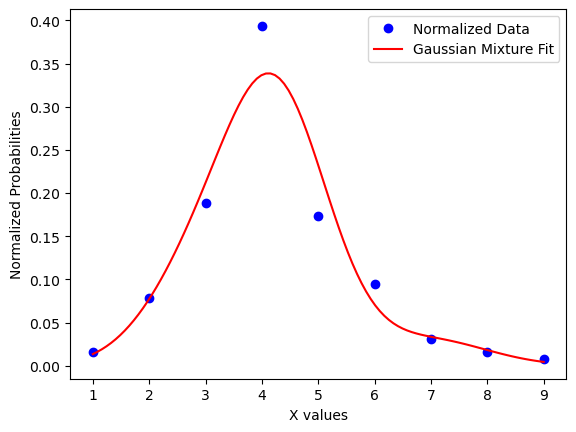

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Input data
xx = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([0.1, 0.5, 1.2, 2.5, 1.1, 0.6, 0.2, 0.1, 0.05])

# Normalize y values to represent probabilities
y_normalized = y / y.sum()

# Create dataset with x values repeated according to their probabilities
x_sample = np.repeat(xx, (y_normalized * 1000).astype(int))

# Number of Gaussians
n_gaussians = 3

# Prepare the data for fitting
X = x_sample[:, np.newaxis]

# Create a GaussianMixture model
gmm = GaussianMixture(n_components=n_gaussians)

# Fit the model to the data
gmm.fit(X)

# Evaluate and visualize the results
xx_range = np.linspace(xx.min(), xx.max(), 100)[:, np.newaxis]
yy_gmm = np.exp(gmm.score_samples(xx_range))

plt.plot(xx, y_normalized, 'bo', label='Normalized Data')
plt.plot(xx_range, yy_gmm, 'r-', label='Gaussian Mixture Fit')
plt.legend()
plt.xlabel('X values')
plt.ylabel('Normalized Probabilities')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_6932\951871622.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  x_sample = np.repeat(xx, (y_normalized * 1000).astype(int))
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


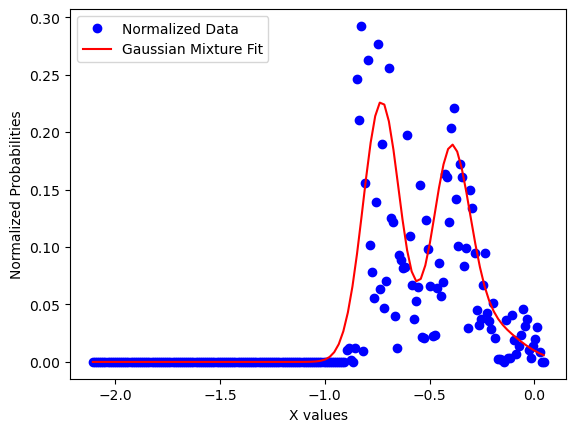

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Input data
xx = look[1]
y = look[0][2][2]

# Normalize y values to represent probabilities
y_normalized = y / y.sum()

# Create dataset with x values repeated according to their probabilities
x_sample = np.repeat(xx, (y_normalized * 1000).astype(int))

# Number of Gaussians
n_gaussians = 3

# Prepare the data for fitting
X = x_sample[:, np.newaxis]

# Create a GaussianMixture model
gmm = GaussianMixture(n_components=n_gaussians)

# Fit the model to the data
gmm.fit(X)

# Evaluate and visualize the results
xx_range = np.linspace(xx.min(), xx.max(), 100)[:, np.newaxis]
yy_gmm = np.exp(gmm.score_samples(xx_range))

plt.plot(xx, y, 'bo', label='Normalized Data')
plt.plot(xx_range, yy_gmm/10., 'r-', label='Gaussian Mixture Fit')
plt.legend()
plt.xlabel('X values')
plt.ylabel('Normalized Probabilities')
plt.show()

C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


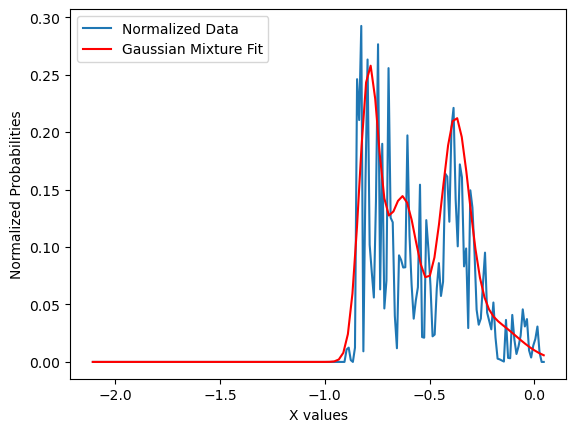

-24.837814275629697


In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
# Input data
xx = look[1]
y = np.real(look[0][2][2])

def gen_gaussfit(xx, y, n_gaussians):
    # Normalize y values to represent probabilities
    y_normalized = y / y.sum()
    # Create dataset with x values repeated according to their probabilities
    x_sample = np.repeat(xx, (y_normalized * 1000).astype(int))
    # Prepare the data for fitting
    X = x_sample[:, np.newaxis]
    # Create a GaussianMixture model
    gmm = GaussianMixture(n_components=n_gaussians)
    # Fit the model to the data
    gmm.fit(X)
    return gmm

gmm = gen_gaussfit(xx, y, 4)
xx_range = np.linspace(xx.min(), xx.max(), 100)[:, np.newaxis]
yy_gmm = np.exp(gmm.score_samples(xx_range))
plt.plot(look[1], y, label='Normalized Data')
plt.plot(xx_range, yy_gmm/10., 'r-', label='Gaussian Mixture Fit')
plt.legend()
plt.xlabel('X values')
plt.ylabel('Normalized Probabilities')
plt.show()
print(gmm.score(xx.reshape(-1, 1), y))

-18.59871784093928